In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import re
import string
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from wordcloud import WordCloud,STOPWORDS
import itertools

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [212]:
#import dataset
df_love = pd.read_csv(r'C:\Users\Shin\Documents\UM\UM\Year 2 Sem 2\WID3006 Machine Learning\Assignment\love.csv')

#separate love letter and non-love letter into two dataframe
df_nonlove = df_love.loc[df_love['labels'] == 0]
df_onlylove = df_love.loc[df_love['labels'] == 1]

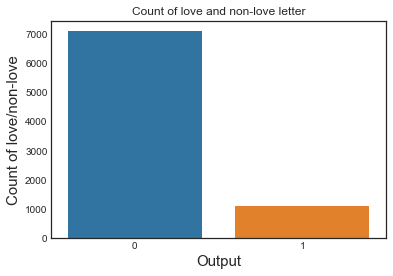

In [213]:
#showing amount of data collected
ax=sns.countplot(x="labels", data=df_love)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of love/non-love',title='Count of love and non-love letter')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

In [214]:
#undersampling
df_nonlove = df_nonlove.sample(frac=1).reset_index(drop=True)
df_nonlove = df_nonlove.iloc[:len(df_onlylove)]

df_love = pd.DataFrame()
df_love = pd.concat([df_onlylove,df_nonlove])
df_love = df_love.sample(frac=1).reset_index(drop=True)
df_love

,text,labels
0,"If only I had known you were out there, then I...",1
1,One day a crab was running on the sea shore..T...,0
2,Another fan here. I even dressed like Alex ...,0
3,Ok ill tell the company,0
4,There are many things in life that people wish...,1
...,...,...
2187,ÌÏ all write or wat..,0
2188,"Yep, drive-ins make great swap meets. The 3 we...",0
2189,But i juz remembered i gotta bathe my dog today..,0
2190,Hey they r not watching movie tonight so i'll ...,0


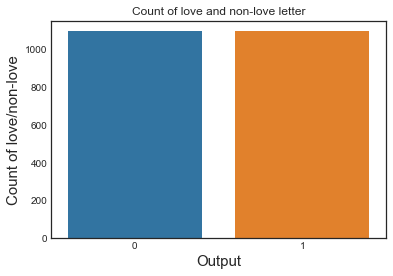

In [215]:
#showing amount of data after undersampling 
ax=sns.countplot(x="labels", data=df_love)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of love/non-love',title='Count of love and non-love letter')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

In [216]:
clean_letter=df_love.copy()

In [217]:
#Make text lowercase, remove text in square brackets,remove punctuation and remove words containing numbers.
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [218]:
#removing stop words
clean_letter['text'] = clean_letter['text'].apply(lambda x:review_cleaning(x))
stop = stopwords.words('english')
clean_letter['text'] = clean_letter['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

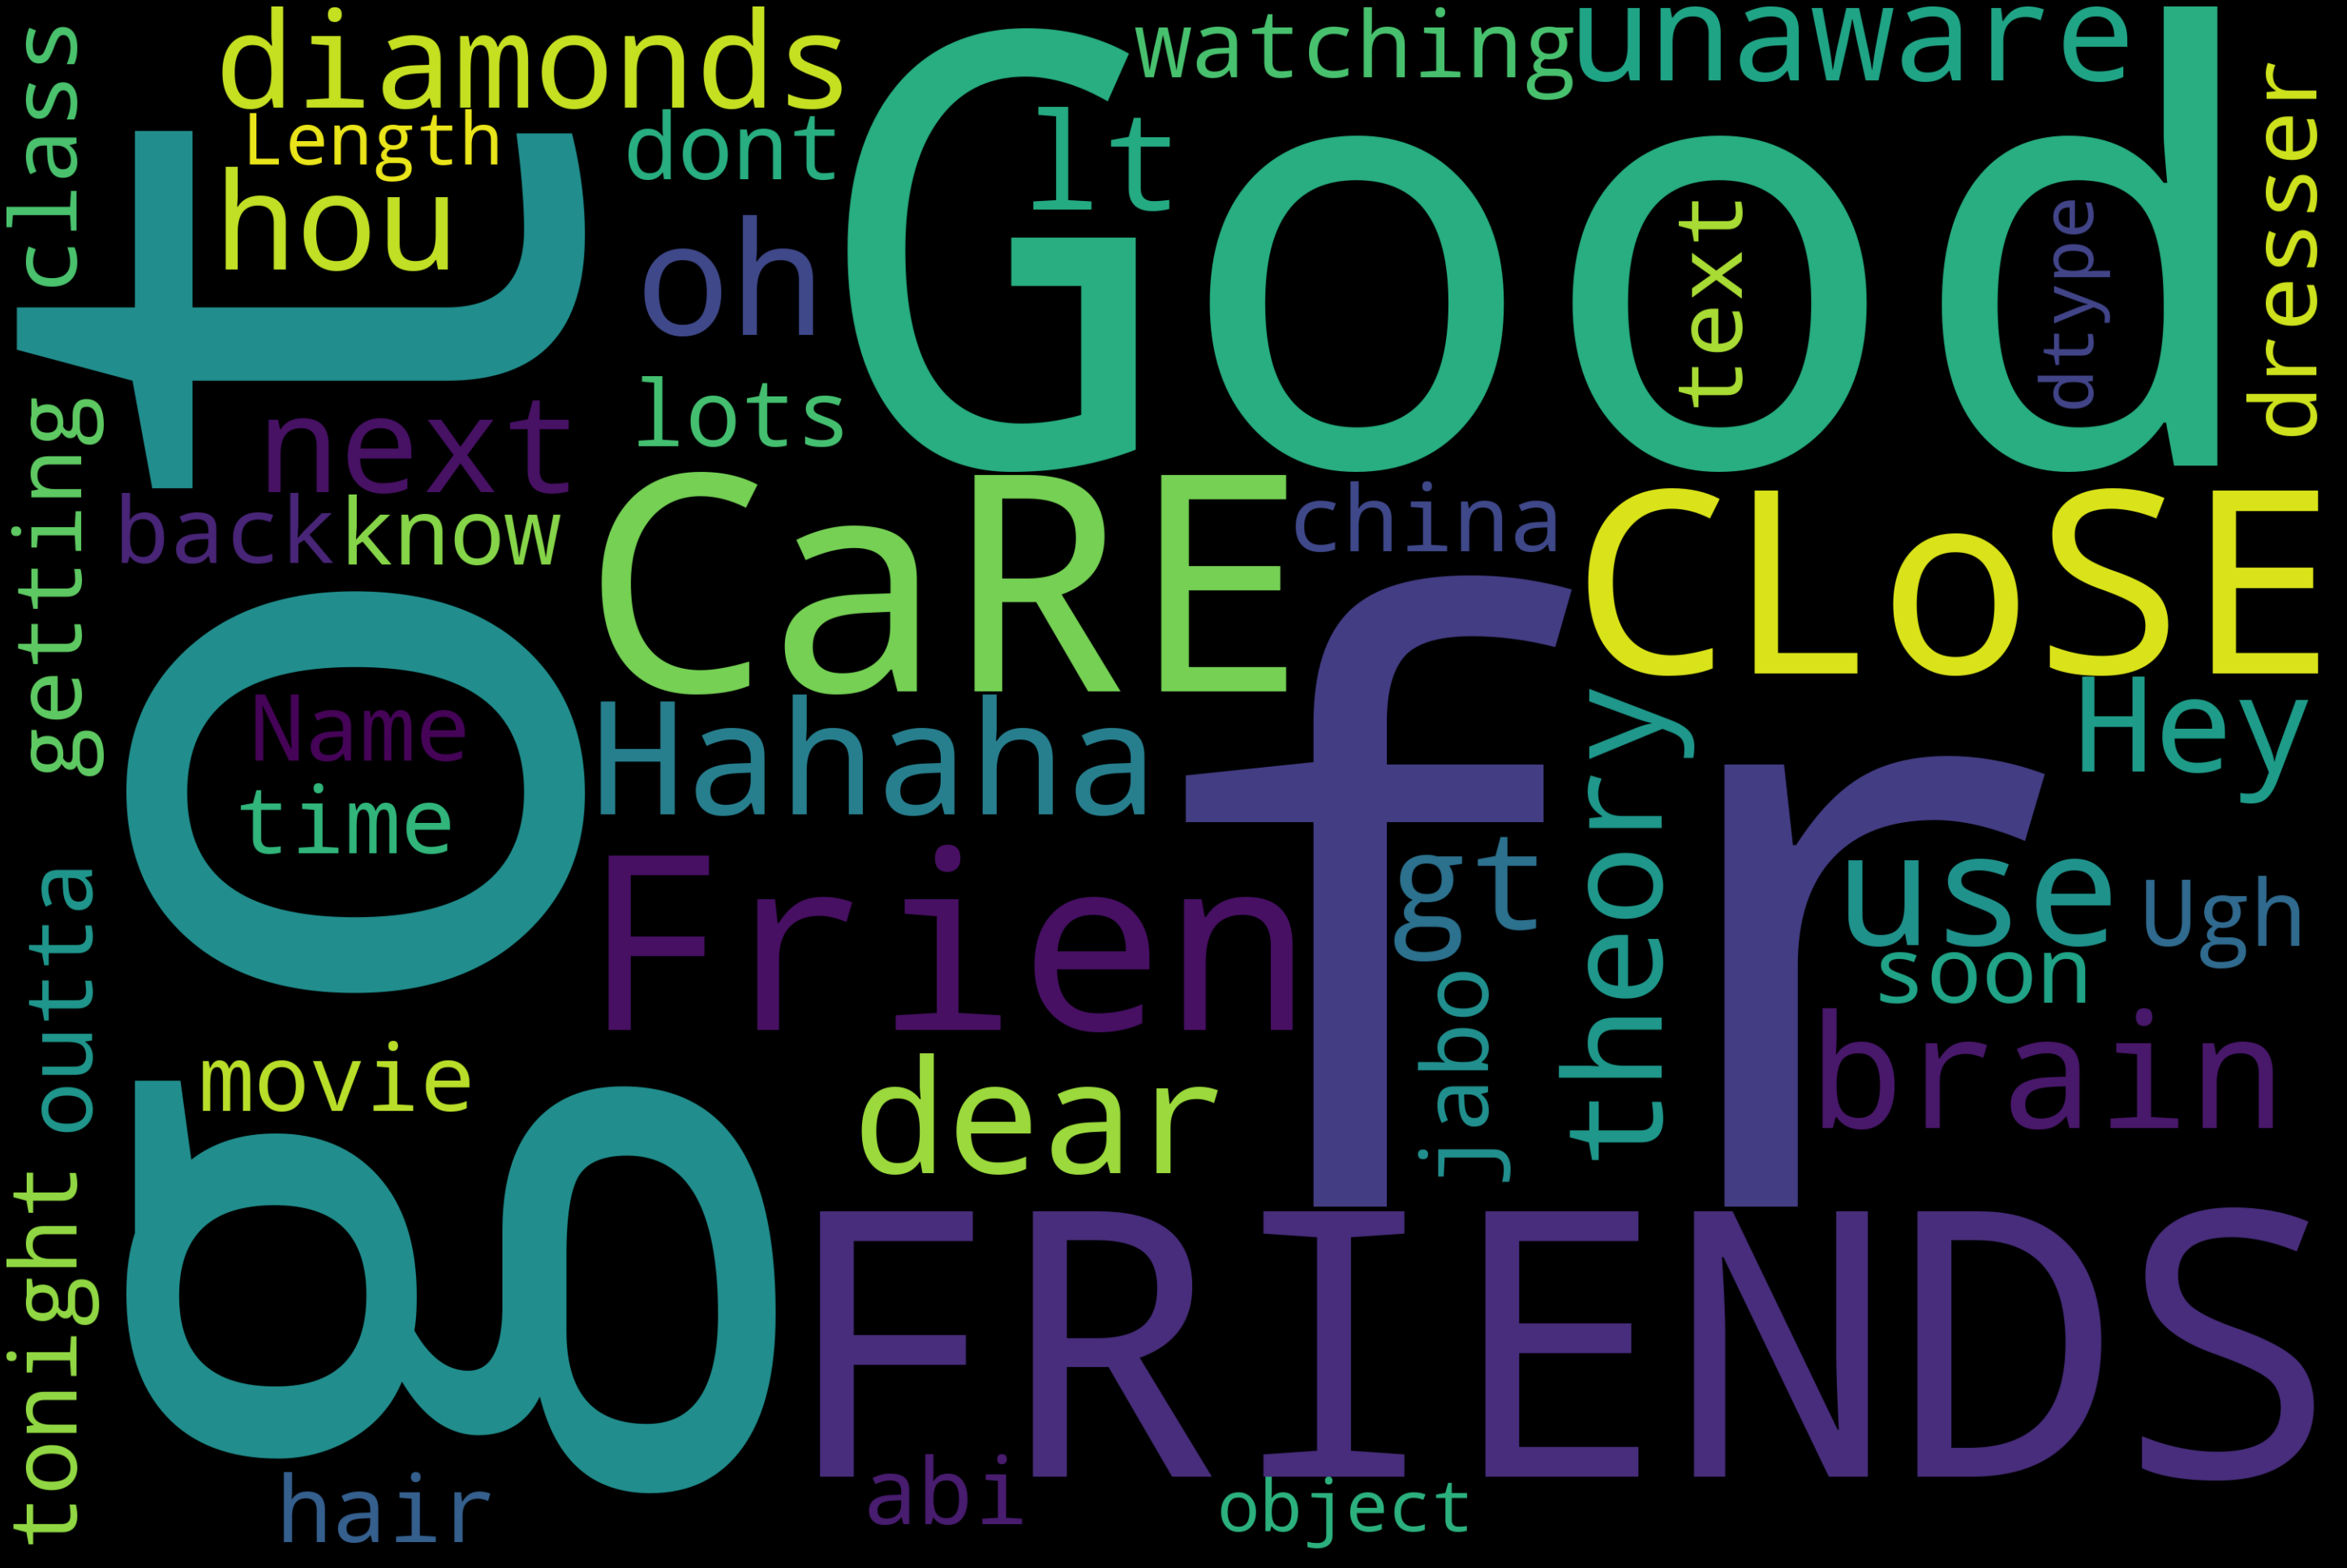

In [219]:
#initialize word cloud of non-love letter
text = df_nonlove["text"]
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

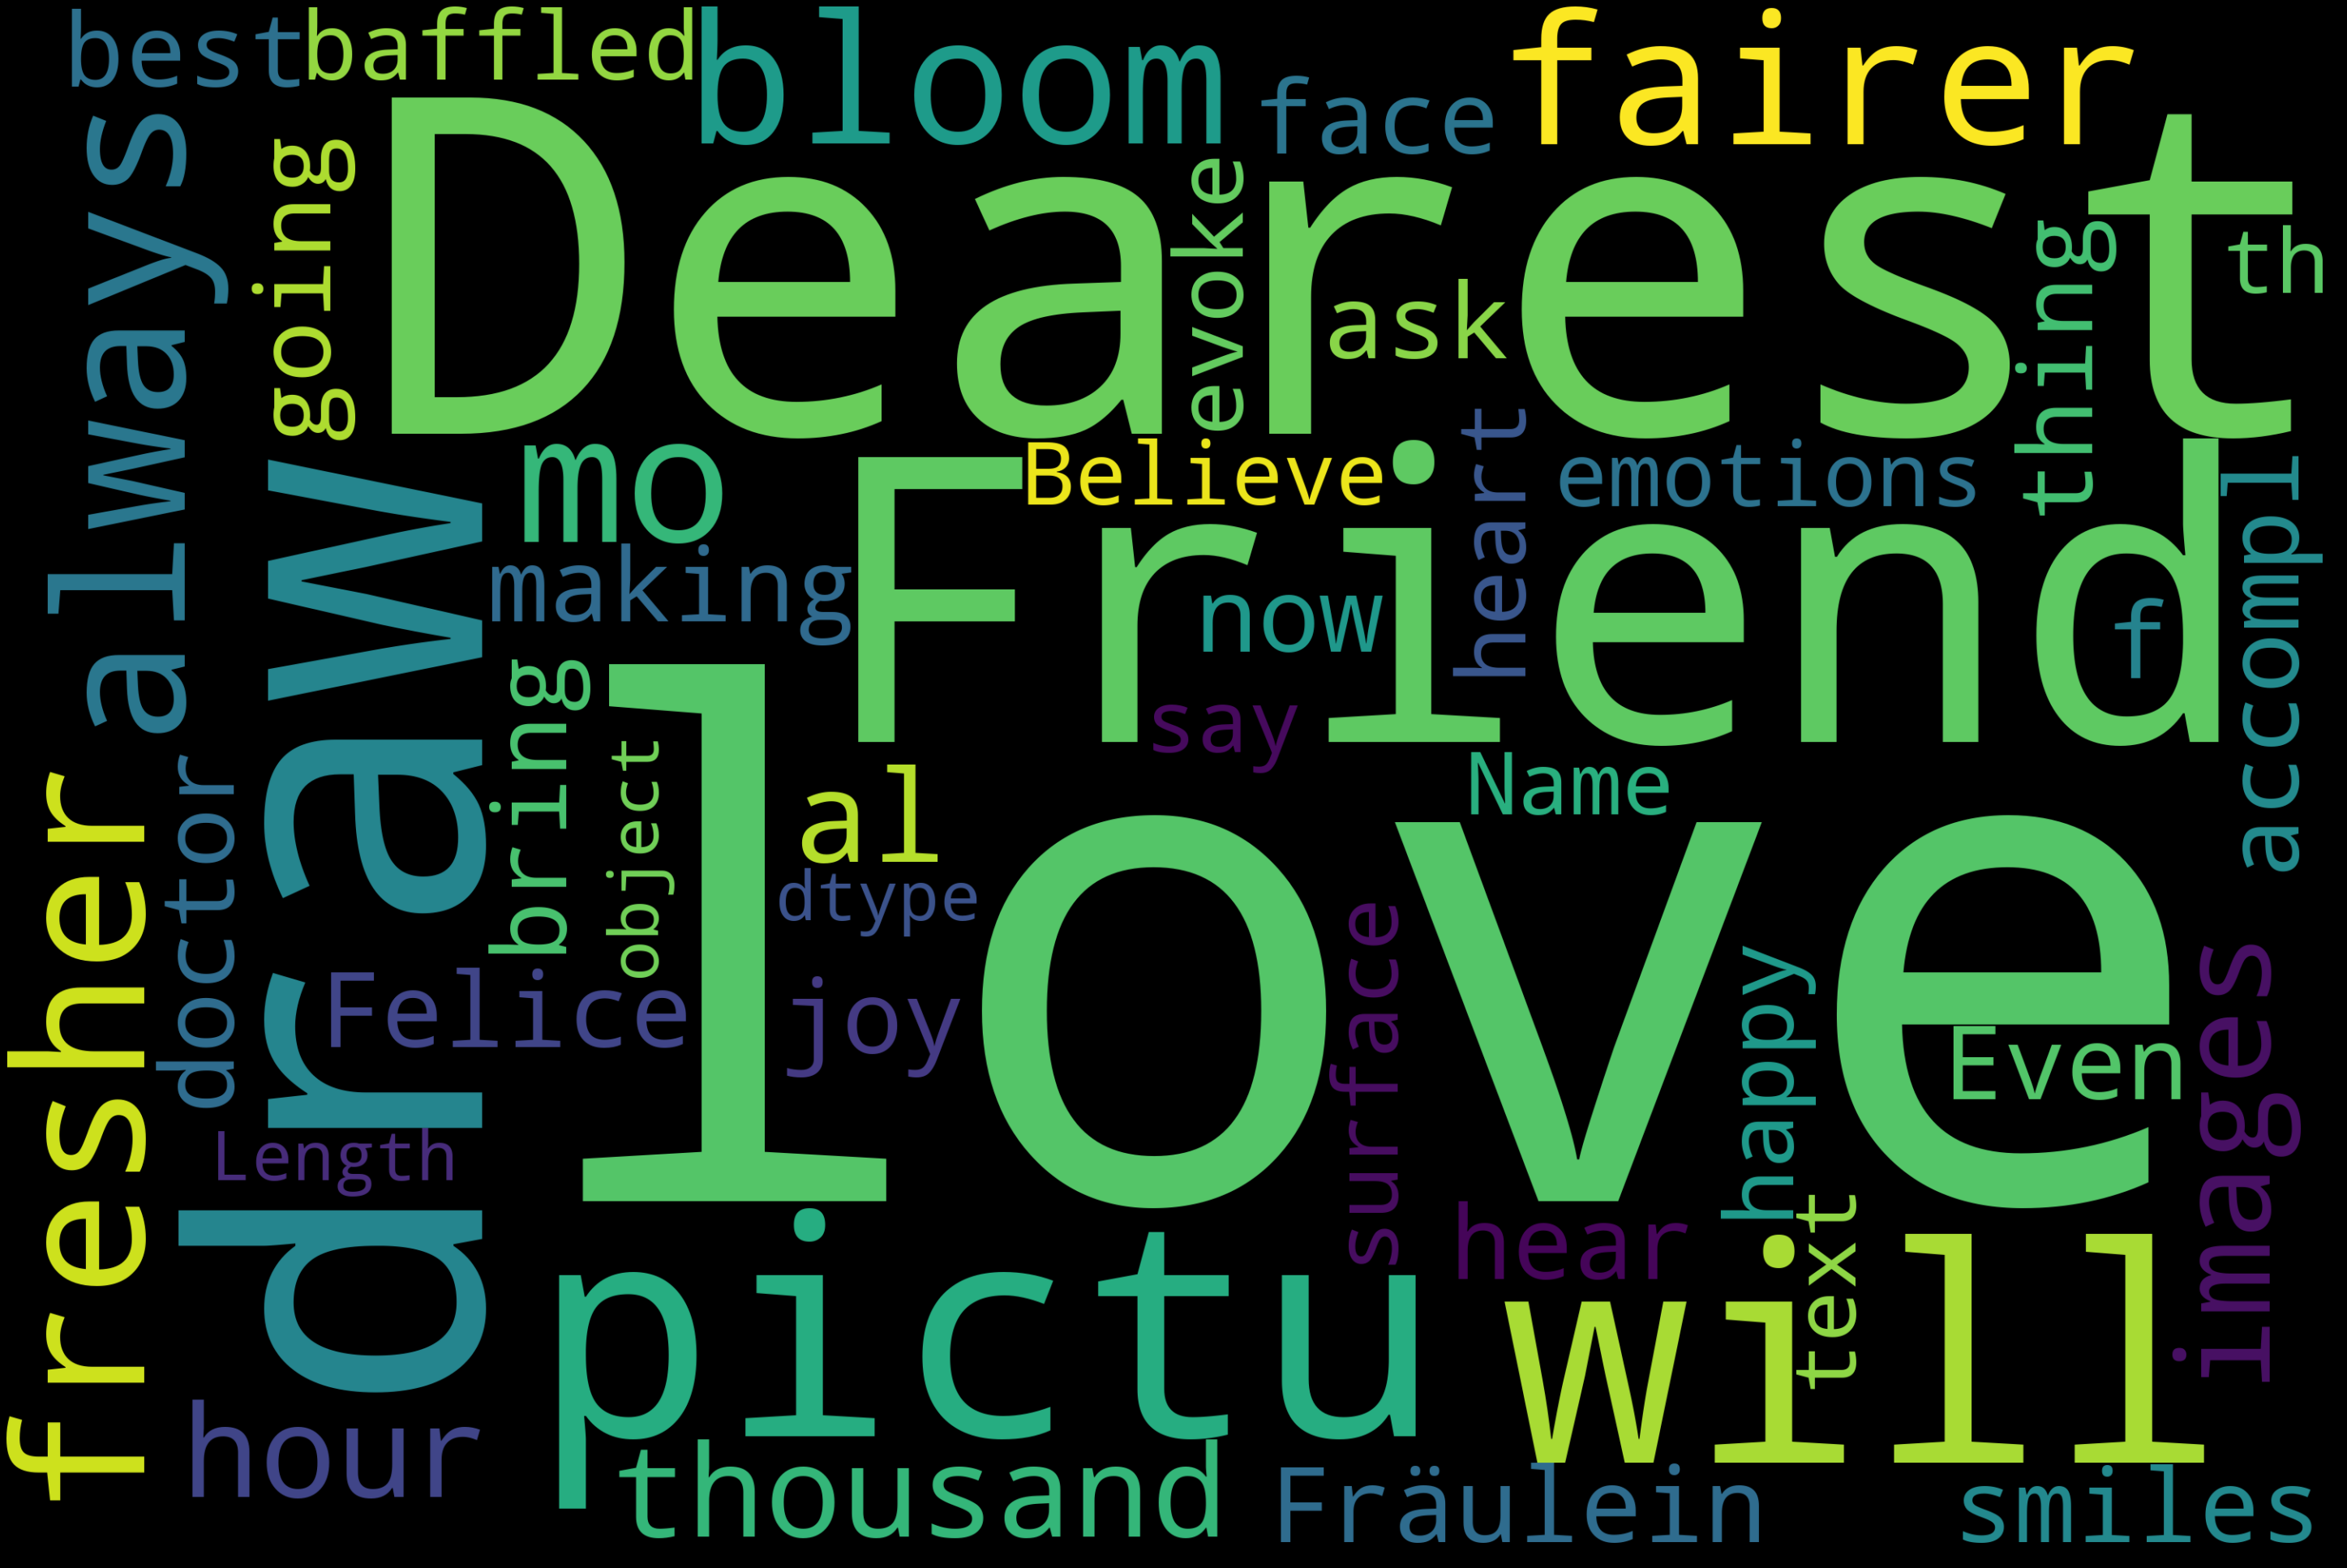

In [220]:
#initialize word cloud of love letter
text = df_onlylove["text"]
wordcloud = WordCloud(width = 3000,height = 2000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



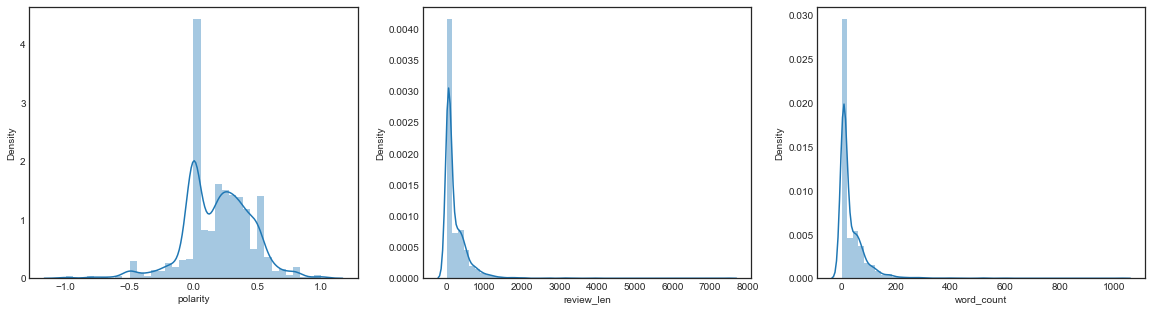

In [221]:
#Extracting the features from the letter
clean_letter['polarity'] = clean_letter['text'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_letter['review_len'] = clean_letter['text'].astype(str).apply(len)
clean_letter['word_count'] = clean_letter['text'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_letter['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_letter['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_letter['word_count'])
fig = plt.gcf()

In [222]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_letter['text'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in letter')

love 2820
know 1191
life 883
want 809
heart 765
never 657
one 653
feel 643
much 630
day 624
would 594
always 591
like 585
time 577
could 513
dont 487
every 483
us 446
im 428
ever 427


In [223]:
y = clean_letter.labels

In [224]:
def check_word(word,list_words):
    if word in list_words:
        print("True")
    else:
        print("False")

In [225]:
#modifying stop words

#getting original stop words
stop = CountVectorizer(stop_words='english').get_stop_words()
list_stop_words = list(stop)

#appending new stop words into the list
check_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't']
tru, fal=0,0

#just to check how long before appending new stop words
print(len(list_stop_words))

for x in check_list:
    if x in list_stop_words:
        tru+=1
    else:
        list_stop_words.append(x)
print("Word found:",tru,"\nWord does not found:",fal)

#check how long is the new list
print(len(list_stop_words))

318
Word found: 114 
Word does not found: 0
332


In [226]:
#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(clean_letter['text'],y,test_size=0.33,random_state=53)

#initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words=list_stop_words)

#transform string data into corpus
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

C:\Users\Shin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



In [227]:
#initialize training model
nb_classifier = MultinomialNB()

#train the model
nb_classifier.fit(count_train,y_train)

#predict how well does the model do 
pred = nb_classifier.predict(count_test)

#get accuracy score
metrics.accuracy_score(y_test,pred)

0.835635359116022

In [228]:
#function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


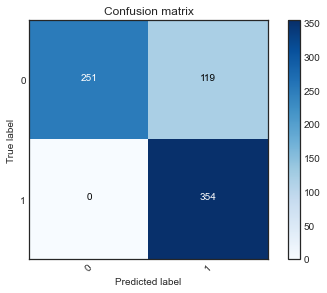

In [229]:
#getting value for confusion matrix
cm = metrics.confusion_matrix(y_test,pred,labels=[0,1])

#plot confusion matrix
plot_confusion_matrix(cm, classes=['0','1'])

In [232]:
test = "I hate you"
test_series = pd.Series(test)
ct_test = count_vectorizer.transform(test_series)
result = nb_classifier.predict(ct_test)
if result == 1:
    print("Love")
else:
    print("Think too much")

Love
